In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [31]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
from tqdm import tqdm

In [32]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [33]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [34]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [35]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [36]:
num_features = 100 #number of dimensions of the input latent variable space(noise)
#defining the generator
generator = tf.keras.Sequential()
generator.add(layers.Dense(7*7*128, input_shape=(num_features,)))
generator.add(layers.Reshape([7, 7, 128]))
generator.add(layers.BatchNormalization())
generator.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', activation='selu'))
generator.add(layers.BatchNormalization())
generator.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding='same', activation='tanh'))

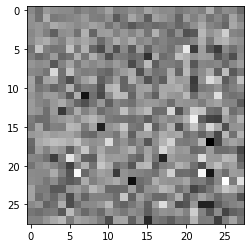

In [39]:
noise = tf.random.normal(shape=(1,num_features))
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [40]:
#defining the discriminator
discriminator = tf.keras.Sequential()
discriminator.add(layers.Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=(28,28,1,)))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
decision = discriminator(generated_image)
print (np.argmax(decision))

In [50]:
# This method returns a helper function to compute cross entropy loss
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [51]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [52]:
def generator_loss(fake_output):
  # fake_out_put : 1 1 0 1 0
  # ones_like : 1 1 1 1 1
    return loss_function(tf.ones_like(fake_output), fake_output)

In [53]:
generator_optimizer = tf.keras.optimizers.RMSprop()
discriminator_optimizer = tf.keras.optimizers.RMSprop()

In [54]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [56]:
seed = tf.random.normal(shape=(BATCH_SIZE, num_features))

In [57]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [58]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [59]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in tqdm(dataset):
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [60]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

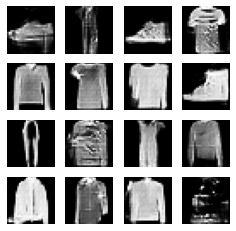

In [61]:
train(train_dataset, EPOCHS)

In [62]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

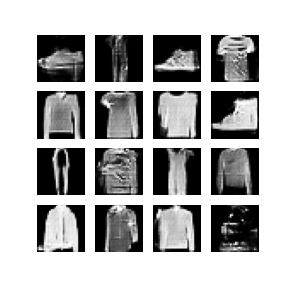

In [64]:
display_image(EPOCHS)

In [65]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


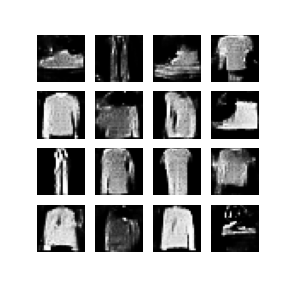

In [66]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)